<a href="https://colab.research.google.com/github/makkimaki/GCIwinter2019_assignments/blob/master/Kaggle_titanic_bcModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"makkimaki04","key":"4a8d19d11c2e04a439ce69b040b23885"}'}

In [0]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [5]:
import os
print(os.getcwd())

/content


In [7]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [8]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 46.6MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.85MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 60.8MB/s]


In [11]:
path = os.getcwd()
print(path)
print(os.listdir())

/content
['.config', 'train.csv', 'adc.json', 'gender_submission.csv', '.kaggle', 'test.csv', 'kaggle (1).json', 'sample_data']


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings 
warnings.filterwarnings("ignore")

In [2]:
addpath = "./input/"
df = pd.read_csv(addpath + "train.csv")
df_test = pd.read_csv(addpath + "test.csv")

#For filling NaN value, cancatenate the data above.
data = pd.concat([df, df_test], sort=False)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
print("Training data shape: {}".format(df.shape))
print("Test data shape: {}".format(df_test.shape))
print("Concatenated data shape {}".format(data.shape))

Training data shape: (891, 12)
Test data shape: (418, 11)
Concatenated data shape (1309, 12)


In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
age = pd.concat([df["Age"], df_test["Age"]])
fare = pd.concat([df["Fare"], df_test["Fare"]])
# print(age)

In [10]:
print("Mean of Age(Training set):", df["Age"].mean())
print("Mean of Age(Test set):", df_test["Age"].mean())

print("Median of Age(Training set):", df["Age"].median())
print("Median of Age(Test set):", df_test["Age"].median())

print("*****************************************************")
print("Mean of Age(concatenated data):", age.mean())
print("Median of Age(concatenated data):", age.median())

Mean of Age(Training set): 29.69911764705882
Mean of Age(Test set): 30.272590361445783
Median of Age(Training set): 28.0
Median of Age(Test set): 27.0
*****************************************************
Mean of Age(concatenated data): 29.881137667304014
Median of Age(concatenated data): 28.0


In [11]:
df["Age"].fillna(age.mean(), inplace=True)
df_test["Age"].fillna(age.mean(), inplace=True)
df["Fare"].fillna(fare.mean(), inplace=True)
df_test["Fare"].fillna(fare.mean(), inplace=True)

df.drop(["Cabin", "Name", "Ticket", "PassengerId"], axis=1, inplace=True)
df_test.drop(["Cabin", "Name", "Ticket", "PassengerId"], axis=1, inplace=True)

df_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [12]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


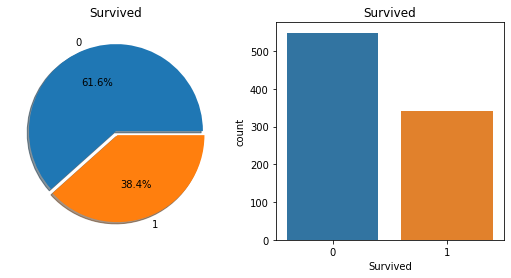

In [13]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))
df["Survived"].value_counts().plot.pie(explode=[0, 0.05], autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title("Survived")
ax[0].set_ylabel("")
sns.countplot("Survived", data=df, ax=ax[1])
ax[1].set_title("Survived")
plt.show()

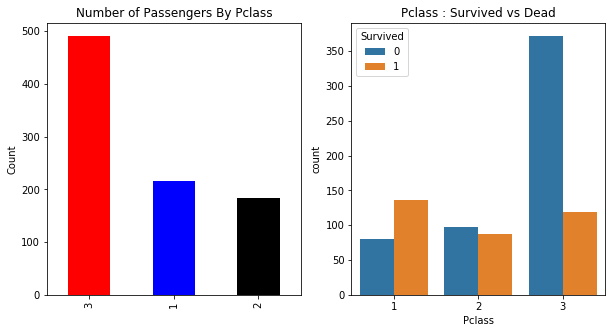

In [14]:
f, ax = plt.subplots(1,2,figsize=(10, 5))
df["Pclass"].value_counts().plot.bar(color=["r", "b", "k"], ax=ax[0])
ax[0].set_title("Number of Passengers By Pclass")
ax[0].set_ylabel("Count")
sns.countplot("Pclass", hue="Survived", data=df, ax=ax[1])
ax[1].set_title("Pclass : Survived vs Dead")
plt.show()

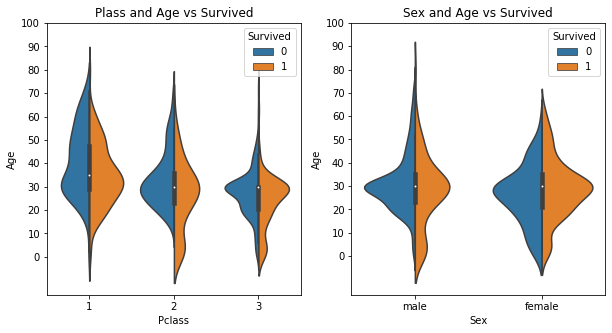

In [15]:
f, ax = plt.subplots(1,2,figsize=(10,5))
sns.violinplot("Pclass", "Age", hue="Survived", data=df, split=True, ax=ax[0])
ax[0].set_title("Plass and Age vs Survived")
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot("Sex", "Age", hue="Survived", data=df, split=True, ax=ax[1])
ax[1].set_title("Sex and Age vs Survived")
ax[1].set_yticks(range(0, 110, 10))
plt.show()

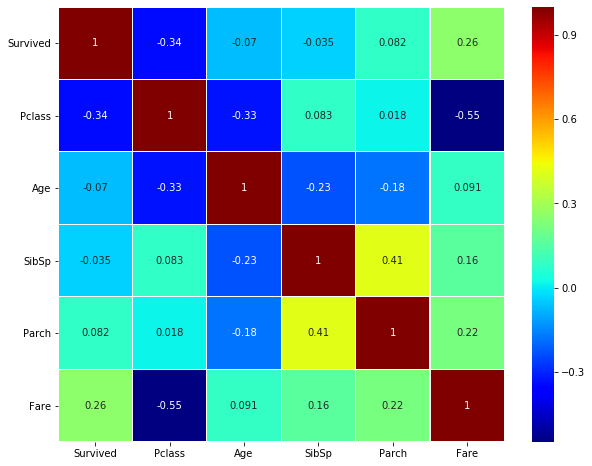

In [16]:
sns.heatmap(df.corr(), annot=True, cmap="jet", linewidth=0.2)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

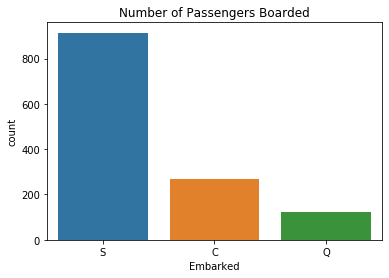

In [17]:
sns.countplot("Embarked", data=data)
plt.title("Number of Passengers Boarded")
plt.show()

In [18]:
df["Embarked"].fillna("S", inplace=True)
df_test["Embarked"].fillna("S", inplace=True)

df_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
dtype: int64

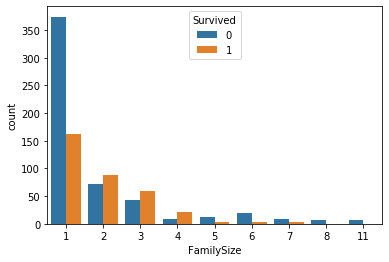

In [19]:
data["FamilySize"] = data["Parch"] + data["SibSp"] + 1
df["FamilySize"] = data["FamilySize"][:len(df)]
df_test["FamilySize"] = data["FamilySize"][len(df):]
sns.countplot(x="FamilySize", data=df, hue="Survived")
df.isnull().sum()
df_test.isnull().sum()

In [20]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,2
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,2
4,0,3,male,35.0,0,0,8.0500,S,1


In [21]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,3,male,34.5,0,0,7.8292,Q,1
1,3,female,47.0,1,0,7.0000,S,2
2,2,male,62.0,0,0,9.6875,Q,1
3,3,male,27.0,0,0,8.6625,S,1
4,3,female,22.0,1,1,12.2875,S,3


In [22]:
data["IsAlone"] = 0
data.loc[data["FamilySize"]==1, "IsAlone"] = 1
df["IsAlone"] = data["IsAlone"][:len(df)]
df_test["IsAlone"] = data["IsAlone"][len(df):]

In [23]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,0,3,male,22.0,1,0,7.2500,S,2,0
1,1,1,female,38.0,1,0,71.2833,C,2,0
2,1,3,female,26.0,0,0,7.9250,S,1,1
3,1,1,female,35.0,1,0,53.1000,S,2,0
4,0,3,male,35.0,0,0,8.0500,S,1,1


In [24]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,male,34.5,0,0,7.8292,Q,1,1
1,3,female,47.0,1,0,7.0000,S,2,0
2,2,male,62.0,0,0,9.6875,Q,1,1
3,3,male,27.0,0,0,8.6625,S,1,1
4,3,female,22.0,1,1,12.2875,S,3,0


In [25]:
embarked = pd.concat([df["Embarked"], df_test["Embarked"]])
embarked_ohe = pd.get_dummies(embarked)

embarked_ohe_train = embarked_ohe[:len(df)]
embarked_ohe_test = embarked_ohe[len(df):]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop("Embarked", axis=1, inplace=True)
df_test.drop("Embarked", axis=1, inplace=True)

In [26]:
df.head()
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,C,Q,S
0,3,male,34.5,0,0,7.8292,1,1,0,1,0
1,3,female,47.0,1,0,7.0000,2,0,0,0,1
2,2,male,62.0,0,0,9.6875,1,1,0,1,0
3,3,male,27.0,0,0,8.6625,1,1,0,0,1
4,3,female,22.0,1,1,12.2875,3,0,0,0,1


In [27]:
cat_features = ["Pclass", "Sex", "Embarked"]

In [28]:
df.replace({"Sex": {"male":0, "female":1}}, inplace=True)
df_test.replace({"Sex": {"male":0, "female":1}}, inplace=True)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,C,Q,S
0,0,3,0,22.0,1,0,7.2500,2,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,2,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,1,1,0,0,1
3,1,1,1,35.0,1,0,53.1000,2,0,0,0,1
4,0,3,0,35.0,0,0,8.0500,1,1,0,0,1


In [29]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,C,Q,S
0,3,0,34.5,0,0,7.8292,1,1,0,1,0
1,3,1,47.0,1,0,7.0000,2,0,0,0,1
2,2,0,62.0,0,0,9.6875,1,1,0,1,0
3,3,0,27.0,0,0,8.6625,1,1,0,0,1
4,3,1,22.0,1,1,12.2875,3,0,0,0,1


# Construct the base model!

In [30]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_test = df_test.iloc[:, 0:].values
X_test.shape

(418, 11)

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
y.shape

(891,)

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

In [33]:
dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=42)
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, oob_score=True, random_state=42)

In [34]:
bc.fit(X_train, y_train)
y_pred = bc.predict(X_valid)
print(y_pred)
y_pred_array = np.array(y_pred)
print("y_pred shape:", y_pred_array.shape)
print("y_valid shape:", y_valid.shape)
acc_valid = accuracy_score(y_valid, y_pred_array)
acc_obb = bc.oob_score_

[0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1
 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1
 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 1 1 0 0 0 0 0]
y_pred shape: (268,)
y_valid shape: (268,)


In [35]:
print("Valid set accuracy: {:.3f}, OOB accuracy : {:.3f}".format(acc_valid, acc_obb))

Valid set accuracy: 0.780, OOB accuracy : 0.814


In [36]:
bc_pred = bc.predict_proba(X_test)

In [37]:
pred = bc_pred.argmax(axis=1)
# print(pred)

In [38]:
submission = pd.read_csv("gender_submission.csv")
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [39]:
submission["Survived"] = pred
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [40]:
submission.to_csv("submission.csv", index=False)

Fold: 0
CV train shape: (801, 12)
Survived listings in CV train(Survivied): 306
Survived listings in CV train(Not Survived): 495

Fold: 1
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 304
Survived listings in CV train(Not Survived): 498

Fold: 2
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 305
Survived listings in CV train(Not Survived): 497

Fold: 3
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 312
Survived listings in CV train(Not Survived): 490

Fold: 4
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 304
Survived listings in CV train(Not Survived): 498

Fold: 5
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 310
Survived listings in CV train(Not Survived): 492

Fold: 6
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 309
Survived listings in CV train(Not Survived): 493

Fold: 7
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 309
Survived l

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

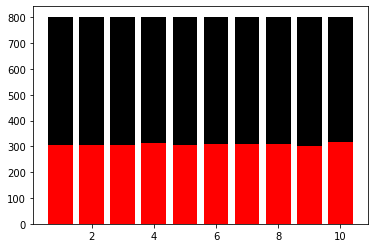

In [69]:
# K-fold cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)

height1 = []
height2 = []
x = np.arange(1, 11, 1)

fold = 0
for train_index, valid_index in kf.split(df):
    # Obtain training and testing folds
    cv_train, cv_valid = df.iloc[train_index], df.iloc[valid_index]
    print("Fold: {}".format(fold))
    print("CV train shape: {}".format(cv_train.shape))
    print("Survived listings in CV train(Survivied): {}".format(sum(cv_train["Survived"] == 1)))
    print("Survived listings in CV train(Not Survived): {}\n".format(sum(cv_train["Survived"] == 0)))
    fold += 1
    height1.append(sum(cv_train["Survived"] == 1))
    height2.append(sum(cv_train["Survived"] == 0))

p1 = plt.bar(x, height1, color="r")
p2 = plt.bar(x, height2, color="k", bottom=np.array(height1))
plt.legend((p1[0], p2[0]), ("Survived", "Not Survived"))


Fold: 0
CV train shape: (801, 12)
Survived listings in CV train(Survivied): 307
Survived listings in CV train(Not Survived): 494

Fold: 1
CV train shape: (801, 12)
Survived listings in CV train(Survivied): 307
Survived listings in CV train(Not Survived): 494

Fold: 2
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 308
Survived listings in CV train(Not Survived): 494

Fold: 3
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 308
Survived listings in CV train(Not Survived): 494

Fold: 4
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 308
Survived listings in CV train(Not Survived): 494

Fold: 5
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 308
Survived listings in CV train(Not Survived): 494

Fold: 6
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 308
Survived listings in CV train(Not Survived): 494

Fold: 7
CV train shape: (802, 12)
Survived listings in CV train(Survivied): 308
Survived l

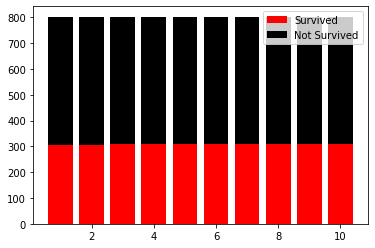

In [71]:
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKfold object
str_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

height1 = []
height2 = []
x = np.arange(1, 11, 1)

# Loop through each split
fold = 0
for train_index, valid_index in str_kf.split(df, df["Survived"]):
    # Obtain training and testing folds
    cv_train, cv_test = df.iloc[train_index], df.iloc[valid_index]
    
    print("Fold: {}".format(fold))
    print("CV train shape: {}".format(cv_train.shape))
    print("Survived listings in CV train(Survivied): {}".format(sum(cv_train["Survived"] == 1)))
    print("Survived listings in CV train(Not Survived): {}\n".format(sum(cv_train["Survived"] == 0)))
    fold += 1

    height1.append(sum(cv_train["Survived"] == 1))
    height2.append(sum(cv_train["Survived"] == 0))

p1 = plt.bar(x, height1, color="r")
p2 = plt.bar(x, height2, color="k", bottom=np.array(height1))
plt.legend((p1[0], p2[0]), ("Survived", "Not Survived"))
